# Data cleaning piple line of earthmoving and mobile-crane

**Author:** _Ming Xu_

**Last update:** _2024.06.24_

In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from data_processing_program_20240520 import deal_special_brand, pre_processing, data_preperation, matching_program, search_regex, search_capacity, mark_unknown_model_with_exsisted_lifting_capacity, mark_outliers, convert_usd_to_cny, update_regex_df, check_col_names, define_load_interval, define_excavator_load_type_interval, check_col_names, matching_program_individual
pd.options.display.float_format = '{:.1f}'.format
import re

# Data pre-processing

In [3]:
# Read dataframe, and input the route to the following code
df = pd.read_excel('Indonesia_842952_May_July.xlsx', sheet_name="Sheet1")

Make sure **'date', 'product description', 'supplier', 'amount in usd', 'weight', 'qty', 'unit'** are existed in the col names

Convert **date** in format

In [4]:
df['date'] = pd.to_datetime(df['date'])

Check units to ensure that they are unified. Exceptions should be checked individually and get unified, e.g., the presence of UNIT and SET in the tables

In [5]:
df['unit'].value_counts()

Number of international units    1185
Set                                94
Piece                              13
aluminium pound only                1
each                                1
Name: unit, dtype: int64

Delete rows that **'amount in usd'** and **'price in usd'**amount in usd **below 10K**.

In [6]:
df = df[df['amount in usd']>=10000]
df = df[df['price in usd']>=10000]
df = df.reset_index(drop=True)

Calculate unit price and net weight in tons

$$unit\ price = \frac{amount}{quantity}$$

$$weight\ (ton) = \frac{weight\ (kg)}{quantity \times 1000}$$

In [7]:
# Converts quantities and weights into numeric format for easy calculation
df['qty'] = pd.to_numeric(df['qty'], errors='coerce')
df['weight in kg'] = pd.to_numeric(df['weight in kg'], errors='coerce')

# Calculate unit price and net weight per unit in ton
df['price in usd'] = df['amount in usd']/df['qty']
df['unit weight in ton'] = df['weight in kg']/df['qty']/1000

In [8]:
# load reference dataframe
df_ref = pd.read_excel('/Users/mingxu/Traymann/ZOOMLION/统计分析报告/8_印度尼西亚/土方/挖掘机/数据处理/数据对照表/型号对照/20240115_土方对照表_含吨位和马力.xlsx', sheet_name="对照表")

_Example of the reference table:_

Abbreviations
* Capacity stands for the load or the max lifting capacity of the model
* hp - Horse power

In [9]:
df_ref.head(3)

,brand,model,capacity,type,model_ref,hp
0,AKERMANVOLVO,750,23.8,EXCAVATOR,750,NaN
1,AKERMANVOLVO,EC 130,13.0,EXCAVATOR,EC 130,NaN
2,AKERMANVOLVO,EC 130 C,13.7,EXCAVATOR,EC 130 C,NaN


**data_preperation(df, df_ref) definition**

* input parameter
    * Original dataframe
    * reference dataframe
* Output
    * Creat a copy of **product description** to avoid the direct modification on original data;
    * Remove the special characters, space and puntuations in product description.

In [10]:
data_preperation(df, df_ref)

# Matching the reference table

Goal: mathcing the exsisted knowledge in the reference table to the processing data.

**matching_program() definition:**
* Input parameters (in order): original dataframe, reference table, file type ('crane' or 'excavator') 
* Output: processed dataframe; error indexes 

**What happened? and what's the standard? **

**1. Mapping the existed knowledge in reference table to the original dataframe**
* Check if any brand existed in product description column -> Mark: Brand in description; Only take the first brand if multipul brands existed
* Check if any brand existed in supplier description column -> Mark: Brand in supplier; Only take the first brand if multiple brands existed
* For rows with brands -> Searching the brand in reference table -> Check if the model existed in product description -> if only a single model match -> Mark: Fully match
* For rows with brands -> Searching the brand in reference table -> Check if the model existed in product description -> if several models match, only take the longest model -> Mark: Multiple model matched, take the longest match
* Nothing matched -> Mark: No match

**2. Delete the irrelevant items**

    Current statistics for irrelevant keywords include the following:

    ['CARRIER', 'TELESCOPLADER', 'HARBOUR', 'OPEN SHEET', 'STACK', 'BOAT', 'BACKHOE', 'SKID', 'ROLLER', 'BENZ', 'TELEHANDLER', 'LOADER', 'FORK', 'PAVER', 'STACKER', 'MATERIAL HANDLER', 'BRIDGE', 'REACH', 'HANDER', 'GRABBER', GANTRY', 'BACK HOE', 'PORT', 'MERCEDES', 'VİNCE', 'SPIDER', 'PIPE', 'HANDLING', 'GLASS CRANE', 'LOAD', 'GRADER', 'GLASS CRANE', 'SPIDER']
                   
**3. Infer product type according to keywords in description**
* Excavator:
    * crawler excavator -> EXCAVATOR
    * wheel **or** tire -> WHEEL EXCAVATOR
    * AMPHIBIOUS -> AMPHIBIOUS EXCAVATOR
    * without the above keywords -> UNKNOWN
* Mobile Crane:
    * Wheel **or** tire -> WHEELED CRANE
    * rough -> ROUGH-TERRAIN CRANE
    * crawler -> CRAWLER CRANE
    * crawler **and** telescopic -> CRAWLER CRANE (TELESCOPIC_BOOM)
    * without the above keywords -> UNKNOWN
    
**4. New or used unit judgement**
* Contain the following keywords: ['USED', 'SECOND HAND', 'SECONDHAND', 'OLD', '2ND HAND', 'REFURBISH']
* Contain a number ranging from 1950 to 2019

    **Mark as used unit**

**5. Parts**
* Contain the following keywords: ['CKD', 'SKD', 'partial'] Mark as **‘Parts’**

In [11]:
# input parameters: original dataframe, reference table, file type (fill in 'crane' or 'excavator')
# output: df with matched info; error row index
df, error_rows_index = matching_program(df, df_ref, file_type='excavator')

In [12]:
# check if contain error rows
error_rows_index.keys()

dict_keys([])

In [13]:
# check the remarks
df['remark'].value_counts()

Fully match                          636
Brands existed but without models    101
No match                              74
Parts                                 21
Name: remark, dtype: int64

# Matching with regular expression
Goal: For data that is no labeled, labeling them by regular expression based on naming rules. 

In [14]:
# Load regex reference table
df_regex = pd.read_excel('/Users/mingxu/Traymann/ZOOMLION/统计分析报告/8_印度尼西亚/土方/挖掘机/数据处理/数据对照表/Regex/20240527_土方REGEX对照表.xlsx',sheet_name='对照表')

**search_regex() definition**
* Original dataframe
* Filter condition(s)
* Searching col
* regex reference table
* Filter brands or not **filter_brand=True/False**
    * True: If the items has been flagged with brand, this function will **only search regexes within the flagged brand**
    * False: Ignore the flagged brand and search through the whole reference table
* Whether to mark working capacity (e.g. tonnage/max lift) **mark_load=True/False**
    * True: mark
    * False: ignore

_Here is an example of how the regex table looks like:_

In [15]:
df_regex.head(3)

,brand,model_regex,capacity_regex,category,starting_point
0,KOMATSU,"PC ?\d{2,3}-?[A-Z]{2}-\d[A-Z]{0,2}",PC ?(\d+),EXCAVATOR,0
1,LIUGONG,"C*L*G* *9\d{2}[EFL][A-Z]{0,2}",(\d+),EXCAVATOR,-1
2,HITACHI,"ZX\d{2,3}[A-Z]{0,3}-[57]?GI?",ZX(\d+),EXCAVATOR,0


The definition of the starting point:
* 0: Mark the capacity with the numeric part divide by 10
* 1: Mark the capacity with the numeric part start from the second number and divide by 10
* 2: There is no relationship and do not mark
* 3: Mart the capacity with the numeric part directly without calculation
* -2: Mark the capacity with the numeric part start from the third number
* -1: Mark the capacity with the numeric part start from the second number

In [16]:
# Aim to have a second search for "Brands existed but without models" and "No match" items
df = search_regex(df, df['remark'].isin(['Brands existed but without models']), 'description2', df_regex, filter_brand=True, mark_load=True)

In [17]:
df = search_regex(df, df['remark'].isin(['No match']), 'description2', df_regex, filter_brand=False, mark_load=True)

**search_capacity() definition**
* Original dataframe
* Filter condition(s)
* Searching col
* regex

Goal: Searching the pattern of **$number + (metric) \ TONS$** in description, and mark the number as maximum lifting capacity

This part of data will be marked as: _Description contains working capacity_

In [18]:
condition = df['capacity']=='UNKNOWN'
search_col = 'description2'
capacity_regex = r'\b(\d+(?:\.\d+)?)\s*(?:METRIC\s*)?TONS?\b'
# (?:METRIC\s*)?: Matches an optional 'METRIC' followed by optional whitespace characters. 
# The (?: ... ) is a non-capturing group.
df = search_capacity(df, condition, search_col, capacity_regex)

In [19]:
df.loc[df['remark'].isin(['Brands existed but without models']),'brand'].unique()

array(['JCB', 'XCMG', 'HENGWANG', 'LANDWORLD', 'LONKING'], dtype=object)

In [20]:
df['remark'].value_counts()

Fully match                                                   636
Unique model match with regex                                  71
No match                                                       44
No brand in description, and unique model match with regex     24
Parts                                                          21
Brands existed but without models                              17
Keep the longest from the multiple matched                     13
Description contains working capacity                           6
Name: remark, dtype: int64

If the lifting capacity is more than 300 tonnes, crawler crane can be judged as Lattice boom

In [21]:
df['capacity'] = pd.to_numeric(df['capacity'], errors='coerce')
# df.loc[(df['type'].isin(['CRAWLER CRANE']))&(df['capacity'].notna())&(df['capacity']>300),'type'] = 'CRAWLER CRANE (LATTICE_BOOM)'

Since CATERILLAR's naming rules is relatively simple and can easily be mislabeled by serial numbers, this issue should be  addressed separately.

In [22]:
df.loc[df['brand']=='CATERPILLAR',['model','type','new/used','remark']].value_counts()

model    type             new/used  remark     
320      EXCAVATOR        new       Fully match    36
330 GC   EXCAVATOR        new       Fully match    10
345 GC   EXCAVATOR        new       Fully match     6
307      EXCAVATOR        new       Fully match     4
313      EXCAVATOR        new       Fully match     4
330      EXCAVATOR        new       Fully match     3
340      EXCAVATOR        new       Fully match     2
305      EXCAVATOR        new       Fully match     1
305.5E2  EXCAVATOR        new       Fully match     1
333      EXCAVATOR        new       Fully match     1
336DL    EXCAVATOR        used      Fully match     1
M320     WHEEL EXCAVATOR  new       Fully match     1
dtype: int64

In [23]:
cat_regex = pd.read_excel('/Users/mingxu/Traymann/ZOOMLION/数据对照表/20240312_土方CAT_REGEX对照表.xlsx',sheet_name='Sheet1')

In [24]:
df = search_regex(df, (df['brand']=='CATERPILLAR')&(df['model']=='UNKNOWN'), 'description2', cat_regex, filter_brand=True, mark_load=True)

In [25]:
df['remark'].value_counts()

Fully match                                                   636
Unique model match with regex                                  71
No match                                                       44
No brand in description, and unique model match with regex     24
Parts                                                          21
Brands existed but without models                              17
Keep the longest from the multiple matched                     13
Description contains working capacity                           6
Name: remark, dtype: int64

# Infer and label the items with existed information

In this section, I will use the labeled items which with the crucial information of ['brand','model','capacity','type'], such as _item A_ to inference the missing info of _item B_. 

Condition: If item A's brand and type are consistent to item B, and its capacity is within the range of ±5% of that of item B.

For instance: A contains all information. B's working capacity is infered from the description via search the patter of number + tons. This function will take ±5% as a threshold, and if A's capacity just fall in this range, then I will label B's model by A.

| item | brand | model | capacity | type |
|------|------|------|------|------|
| A    | ✓    | ✓    | ✓    | ✓    |
| B    | ✓    | ✘    | ✓    | ✓    |

In [26]:
df = mark_unknown_model_with_exsisted_lifting_capacity(df)

In [27]:
# Calculate the amount and quantity of no matched items
unlabeled_value = round(df.loc[df['remark'] == 'No match','amount in usd'].sum(),1)
unlabeled_qty = df.loc[df['remark'] == 'No match','qty'].sum()
print(f'No match items amount: $ {round(unlabeled_value,2)}')
print(f'No match items qty: {unlabeled_qty} units')

No match items amount: $ 11836788.2
No match items qty: 177 units


# Mark the outliers

Check if N/A value contains

In [28]:
df['unit weight in ton'].isna().sum()

183

**mark_outliers(df, term=True) definition**
* Input paramter:
    * original dataframe
    * term: choose from **True/False**; Note: If the data contains shipping terms, true could be filled, and make sure there is a column "term" in dataframe
        * True: The outlier judgment will be based on the brand, model, and terms as the filtering conditions, and the **median price** in the case that the above three marks are satisfied at the same time will be taken as the reference standard;
        * False：If the original dataframe does not contain terms, fill in false will ignore terms and **will only take the median price under the same brand and model** according to the above criteria.

**Goal:** Find out the outlier items for further price analysis

**Price outlier judgement criteria:**

Calculate the median price of models under the same brand, if trade terms exist, make a judgment under the same trade terms
* Unknown: unknown model, used machine;
* Normal: item prices within median ± median*20%;
* Outlier: prices outside the aforementioned threshold.

In [29]:
df = mark_outliers(df, term=False)

# Working capacity interval division
**define_load_interval(df, file_type, load_interval)**

Input parameters:

* Original dataframe
* File_type: should fill in **crane** or **excavator**; Notice: the interval definition differs from file types
* Define the load interval
   * For example: define the interval as the specified number. If fill in 50, I will return ≤50T, 50-100T, 100-150T, and so forth.

**Mobile crane**

* There are cases where the lifting capacity is much larger than the self-weight of the equipment itself, and it varies from types, so it can't speculate by the weight of the equipment itself;
* Will only mark the interval of items that are labeled with lifting capacity.
    
    
**Excavator**

The work load of excavator is almost identical to the weight of itself, and for unknown items will be divided by weight
* Define the interval of known items
* Define the interval of unknown items by weight

In [30]:
define_load_interval(df, file_type = 'excavator', load_interval = 10)

In [31]:
define_excavator_load_type_interval(df)

In [32]:
df['type interval'].value_counts()

10-30T     344
5-10T      188
30-70T     139
<5T        137
≥90T        12
70-90T       6
UNKNOWN      6
Name: type interval, dtype: int64

In [33]:
df['capacity interval'].value_counts()

20-30T      256
5-10T       188
<5T         137
30-40T       94
10-20T       88
40-50T       36
100-110T      9
50-60T        8
70-80T        5
UNKNOWN       3
120-130T      2
200-210T      1
80-90T        1
60-70T        1
Name: capacity interval, dtype: int64

In [34]:
df['type interval'] = df['type interval'].fillna('UNKNOWN')
df['capacity interval'] = df['capacity interval'].fillna('UNKNOWN')

# Exchange rate conversion

**convert_usd_to_cny(df, rate_dict)**

Input parameters:
* Original dataframe: make sure ['date', 'price in usd', 'amount in usd'] columns are in dataframe
* Exchange rate dictionary: a dictionary file, and should fill in the latest USD-CNY rate to "rate_dict". Historical data will be calculated automatically based on the date.

In [35]:
rate_dict = {2023: {1: 6.7604, 2: 6.9519, 3: 6.8717, 4: 6.924, 5: 7.0821, 6: 7.2258, 7: 7.1305, 8: 7.1811, 9: 7.1798, 10: 7.1779, 11: 7.1018, 12: 7.0827},
             2024: {1: 7.1039, 2: 7.1036, 3: 7.0950, 4:7.1063, 5:7.1088, 6:7.1268, 7: 7.1346}}

df = convert_usd_to_cny(df, rate_dict)

In [36]:
# remove the extra marks
df['model'] = df['model'].apply(lambda x: x.replace(' ',''))
df['model'] = df['model'].apply(lambda x: x.lstrip())
df['model'] = df['model'].apply(lambda x: x.rstrip())

# Data Analysis

Import analysis functions

In [37]:
from data_processing_program_20240520 import key_players_table, show_key_palyers, key_capacity_interval, top3_players

## Key players in the market

In [38]:
df_keyplayer = key_players_table(df)
df_keyplayer

,Brand,Amount $,Units #,Amount %,Unit %
0,SANY,52.2 M,798,27.4%,29.1%
1,KOMATSU,30.8 M,396,16.2%,14.5%
2,KOBELCO,17.4 M,314,9.1%,11.5%
3,LIUGONG,12.7 M,235,6.7%,8.6%
4,LIEBHERR,10.2 M,7,5.3%,0.3%
5,CATERPILLAR,8.6 M,70,4.5%,2.6%
6,ZOOMLION,7.6 M,80,4.0%,2.9%
7,HYUNDAI,7.0 M,98,3.7%,3.6%
8,OTHERS,31.6 M,544,16.6%,19.9%
9,UNKNOWN,12.4 M,198,6.5%,7.2%


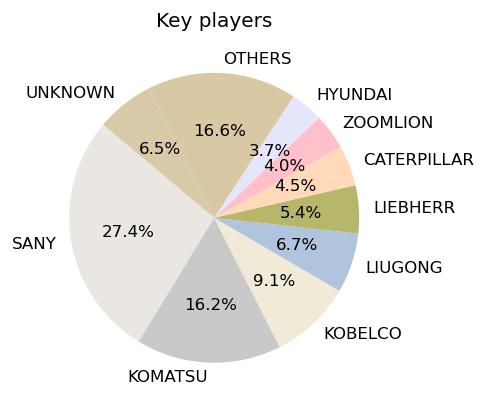

In [42]:
show_key_players(df_keyplayer)

## Main sale intervals

In [43]:
key_capacity_interval(df)

,Capacity,Amount $,Units #,Amount %,Unit %
0,20-30T,72.0 M,1104,37.8%,40.3%
1,30-40T,35.9 M,303,18.9%,11.1%
2,5-10T,22.6 M,720,11.9%,26.3%
3,100-110T,13.4 M,14,7.0%,0.5%
4,10-20T,11.1 M,199,5.8%,7.3%
5,50-60T,9.5 M,53,5.0%,1.9%
6,40-50T,8.4 M,39,4.4%,1.4%
7,<5T,7.3 M,266,3.8%,9.7%
8,70-80T,3.5 M,10,1.9%,0.4%
9,200-210T,3.0 M,1,1.6%,0.0%


## Top 3 players

In [45]:
top3_players(df)

,Brand,Amount $,Units #,Amount %,Unit %
0,SANY,52.2 M,798,27.4%,29.1%
1,KOMATSU,30.8 M,396,16.2%,14.5%
2,KOBELCO,17.4 M,314,9.1%,11.5%


**The code below only use for mobile crane data processing**
* Merge the tranlation to dataframe

In [ ]:
# EN_CN = pd.read_excel('/Users/mingxu/Traymann/ZOOMLION/数据对照表/工起类型分类对照表.xlsx',sheet_name='Sheet1')

In [ ]:
# df = pd.merge(df, EN_CN, how='left', on='类型')

Save the file

In [ ]:
# df.to_excel('/Users/mingxu/Traymann/ZOOMLION/统计分析报告/8_印度尼西亚/土方/挖掘机/数据处理/2024年一季度印尼挖掘机进口数据_已清理和异常判断.xlsx', sheet_name='Sheet1', index=False)

# Update historical data

Concatenate the historical to the latest.
* Make sure the processing logic are aligned;
* Make sure the column names of both dataframes are identical.

In [70]:
df_hist = pd.read_excel('/Users/mingxu/Traymann/ZOOMLION/统计分析报告/8_印度尼西亚/土方/挖掘机/2022年8-2024年4月印尼挖掘机进口数据_已清理及异常判断.xlsx',sheet_name='Sheet1')

**check_col_names(df.columns, df_hist.columns)**

Check the identity

Check that the column names of the merged tables are consistent, with ORIGINAL on the left and REFERENCE on the right; as long as it is satisfied that the column names of one of the files are a subset of another file

In [77]:
check_col_names(df.columns, df_hist.columns)

Columns in the reference df but not in original: {'hp', 'datasource', 'weight'}


Concatenate historical data

In [78]:
df_updated = pd.concat([df_hist, df], axis=0, ignore_index=True)

In [79]:
df_updated['model'] = df_updated['model'].apply(lambda x: x.replace(' ',''))
df_updated['model'] = df_updated['model'].apply(lambda x: x.lstrip())
df_updated['model'] = df_updated['model'].apply(lambda x: x.rstrip())

In [97]:
# Save file
df_updated.to_excel('/Users/mingxu/Downloads/Indonesia_excavator_2022_2024.07.xlsx',sheet_name='Sheet1',index=False)

## A glance of 2024

In [47]:
df_2024 = df_updated[df_updated['date'].dt.year==2024]
key_players_table(df_2024)

,Brand,Amount $,Units #,Amount %,Unit %
0,SANY,140.4 M,2104,32.5%,32.4%
1,KOMATSU,64.8 M,732,15.0%,11.3%
2,KOBELCO,38.1 M,643,8.8%,9.9%
3,CATERPILLAR,20.5 M,150,4.7%,2.3%
4,LIUGONG,17.7 M,337,4.1%,5.2%
5,ZOOMLION,17.1 M,273,4.0%,4.2%
6,VOLVO,17.1 M,127,3.9%,2.0%
7,HITACHI,13.9 M,162,3.2%,2.5%
8,OTHERS,79.1 M,1364,18.3%,21.0%
9,UNKNOWN,23.3 M,599,5.4%,9.2%


In [80]:
# df_2024[df_2024['brand'].isin(['SANY'])].pivot_table(index='brand', columns='model', 
#                                                 values='amount in usd', aggfunc='sum').T.sort_values(by='SANY', ascending=False)

In [153]:
df_2023 = df_updated[df_updated['date'].dt.year==2023]
key_players_table(df_2023)

,Brand,Amount $,Units #,Amount %,Unit %
0,KOMATSU,178.9 M,600,21.0%,6.2%
1,SANY,126.7 M,2221,14.9%,23.0%
2,HITACHI,107.0 M,479,12.6%,5.0%
3,KOBELCO,101.6 M,1526,11.9%,15.8%
4,XCMG,77.0 M,983,9.1%,10.2%
5,ZOOMLION,41.8 M,754,4.9%,7.8%
6,LIEBHERR,33.5 M,23,3.9%,0.2%
7,LIUGONG,28.7 M,512,3.4%,5.3%
8,OTHERS,155.8 M,2549,18.3%,26.4%


In [154]:
top3_players(df_2024)

,Brand,Amount $,Units #,Amount %,Unit %
0,SANY,140.4 M,2104,32.5%,32.4%
1,KOMATSU,64.8 M,732,15.0%,11.3%
2,KOBELCO,38.1 M,643,8.8%,9.9%


In [160]:
key_capacity_interval(df_2024)

,Capacity,Amount $,Units #,Amount %,Unit %
0,20-30T,153.9 M,2329,35.6%,35.9%
1,30-40T,80.5 M,660,18.6%,10.2%
2,5-10T,57.8 M,2271,13.4%,35.0%
3,10-20T,23.7 M,422,5.5%,6.5%
4,40-50T,22.9 M,104,5.3%,1.6%
5,50-60T,20.9 M,114,4.8%,1.8%
6,200-210T,19.7 M,7,4.6%,0.1%
7,100-110T,14.2 M,16,3.3%,0.2%
8,<5T,9.6 M,409,2.2%,6.3%
9,70-80T,8.9 M,27,2.1%,0.4%
